## Book Copurchase Graph Analysis

#### by Ingine Hmwe
-------


#### Table of Contents

* Introduction
* Data Import and Formatting
* Data Exploration
* Preprocess for Graph and Network Analysis
* Visualization

### Imports

In [1]:
import cudf
import cugraph
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

### Introduction to Dataset

Dataset is the filtered version of Amazon Product co-purchasing network metadata taken from SNAP http://snap.stanford.edu/data/amazon-meta.html. 
The original dataset includes about 548,552 different products (Books, music CDs, DVDs, and VHS video tapes)
The dataset used contains book items only.
The data was collected in summer 2006.

### Load and Explore Dataset

In [2]:
dataset_path = '../../data/amazon-books.csv'

In [3]:
%%time
gdf = cudf.DataFrame()
gdf = cudf.read_csv(dataset_path)

CPU times: user 552 ms, sys: 364 ms, total: 917 ms
Wall time: 918 ms


### Exploration

Let's see how the data looks like. 
ASIN is the identifier for Amazon Book. Copurchased column contains a list of books that are commmonly purchased along with the book in ASIN column. These Copurchased data are collected from the Amazon Recommendation section "Customers who bought this item also bought".

In [4]:
%%time
gdf.head().to_pandas()

CPU times: user 348 ms, sys: 10.2 ms, total: 358 ms
Wall time: 356 ms


,Id,ASIN,Title,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,subjects religion preaching clergy spiritualit...,Book,0804215715 156101074X 0687023955 0687074231 08...,396585,2,2.0
1,2,0738700797,Candlemas: Feast of Flames,subjects witchcraft earth religion based spiri...,Book,0738700827 1567184960 1567182836 0738700525 07...,168596,12,12.0
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,general subjects hobbies home garden crafts books,Book,None,1270652,1,1.0
3,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,subjects life bibles christian general history...,Book,0842328130 0842330313 0842328610 0842328572,631289,1,1.0
4,5,1577943082,Prayers That Avail Much for Business: Executive,subjects religion prayerbooks devotion worship...,Book,157794349X 0892749504 1577941829 0892749563,455160,0,0.0


Notice that some of the copurchased data for the respective books are missing ("None"). Let's find out how many of them are missing.

In [5]:
# dataset contains 392966 rows.
%time gdf.shape

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 11.2 µs


(392966, 9)

In [6]:
# And all the books are unique
%time gdf.ASIN.unique().shape[0]

CPU times: user 4.61 ms, sys: 8.54 ms, total: 13.1 ms
Wall time: 12.6 ms


392966

In [7]:
%%time
# Fill None with empty string for Object Type Columns.
gdf['Copurchased'] = gdf['Copurchased'].fillna('')
gdf['Categories'] = gdf['Categories'].fillna('')

CPU times: user 3.98 ms, sys: 7.99 ms, total: 12 ms
Wall time: 11.5 ms


In [8]:
# There are 126553 records, 32% of the data are missing Copurchased info.
%time gdf[gdf.Copurchased == ''].shape[0] / gdf.shape[0]

CPU times: user 197 ms, sys: 68.7 ms, total: 266 ms
Wall time: 274 ms


0.32204567316256366

These missing Copurchased records are not gonna help us in finding which books are most similar to them. So we will reduce the number of book records.

In [9]:
%time reduced_gdf = gdf[gdf.Copurchased != '']

CPU times: user 44.6 ms, sys: 24.5 ms, total: 69.1 ms
Wall time: 69.2 ms


In [10]:
%time reduced_gdf.shape[0]

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 11.4 µs


266413

### Preprocessing for Graph Edgelist

Convert cudf to Pandas to use the Pandas APIs needed to split (explode) a column into multiple rows

In [11]:
%time pd_df = reduced_gdf.to_pandas()

CPU times: user 327 ms, sys: 119 ms, total: 446 ms
Wall time: 444 ms


In [12]:
%time pd_df.head(2)

CPU times: user 924 µs, sys: 0 ns, total: 924 µs
Wall time: 830 µs


,Id,ASIN,Title,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,subjects religion preaching clergy spiritualit...,Book,0804215715 156101074X 0687023955 0687074231 08...,396585,2,2.0
1,2,0738700797,Candlemas: Feast of Flames,subjects witchcraft earth religion based spiri...,Book,0738700827 1567184960 1567182836 0738700525 07...,168596,12,12.0


Create new dataframe, splitting books in Copurchased into individual rows with ASIN as the index

In [13]:
%time new_pd_df = pd.DataFrame(pd_df.Copurchased.str.split(' ').tolist(), index=pd_df.ASIN).stack()

CPU times: user 767 ms, sys: 60.7 ms, total: 828 ms
Wall time: 826 ms


In [14]:
%time new_pd_df.head(6)

CPU times: user 303 µs, sys: 0 ns, total: 303 µs
Wall time: 309 µs


ASIN         
0827229534  0    0804215715
            1    156101074X
            2    0687023955
            3    0687074231
            4    082721619X
0738700797  0    0738700827
dtype: object

In [15]:
# get rid of secondary index
# make ASIN as a column (it can't be an index since the values will be duplicate)
%time new_pd_df = new_pd_df.reset_index([0, 'ASIN'])

CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 32.9 ms


In [16]:
%time new_pd_df.head(2)

CPU times: user 341 µs, sys: 229 µs, total: 570 µs
Wall time: 479 µs


,ASIN,0
0,0827229534,0804215715
1,0827229534,156101074X


In [17]:
# to save memory, select only the columns we need for our graph
# rename column '0' to column 'Copurchase_ASIN'
%time new_pd_df.columns = ['ASIN', 'Copurchased_ASIN']

CPU times: user 476 µs, sys: 319 µs, total: 795 µs
Wall time: 786 µs


In [18]:
%time new_pd_df.head(2)

CPU times: user 521 µs, sys: 349 µs, total: 870 µs
Wall time: 841 µs


,ASIN,Copurchased_ASIN
0,0827229534,0804215715
1,0827229534,156101074X


In [19]:
%%time
new_gdf = cudf.from_pandas(new_pd_df)

CPU times: user 109 ms, sys: 32.5 ms, total: 141 ms
Wall time: 140 ms


In [20]:
%%time
# Merge exploded rows of Copurchased into original dataset.
combined_gdf = cudf.merge(new_gdf, gdf, on=['ASIN']).sort_values(['ASIN'])

CPU times: user 228 ms, sys: 132 ms, total: 360 ms
Wall time: 369 ms


In [21]:
%%time
combined_gdf.head(3).to_pandas()

CPU times: user 43.4 ms, sys: 6.78 ms, total: 50.2 ms
Wall time: 48 ms


,ASIN,Copurchased_ASIN,Id,Title,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating
439629,0001047655,0061007129,271961,Prodigal Daughter,general tape subjects literature contemporary ...,Book,0061007129 0061007358 0061007137 0061099341 00...,1116690,30,30.0
439630,0001047655,0061007358,271961,Prodigal Daughter,general tape subjects literature contemporary ...,Book,0061007129 0061007358 0061007137 0061099341 00...,1116690,30,30.0
439631,0001047655,0061007137,271961,Prodigal Daughter,general tape subjects literature contemporary ...,Book,0061007129 0061007358 0061007137 0061099341 00...,1116690,30,30.0


Remove Copurchased Columns which is redundant.

In [22]:
%%time
combined_gdf = combined_gdf.drop('Copurchased')
combined_gdf = combined_gdf.drop('Group')

CPU times: user 15.5 ms, sys: 11.7 ms, total: 27.2 ms
Wall time: 25.5 ms


### Book-to-Book Network

We will form a Unipartite Graph between ASIN and Copurchased_ASIN. Based on the cuGraph requirements, we have to convert the aforementioned columns' Object Datatype to int32 type and renumber the vertex ids to start from 0. So we will be creating columns of renumbered source vertex ids and destination vertex ids, both will be in int32 type. The numbering map from renumbering will map the new ids to original ids. The current renumbering API from cuGraph only support int32 type.

In [23]:
%%time
combined_gdf.dtypes

CPU times: user 416 µs, sys: 0 ns, total: 416 µs
Wall time: 422 µs


ASIN                 object
Copurchased_ASIN     object
Id                    int64
Title                object
Categories           object
SalesRank             int64
TotalReviews          int64
AvgRating           float64
dtype: object

In [24]:
%%time
combined_gdf.add_column('ASIN_int', combined_gdf['ASIN'].astype('int32'))
combined_gdf.add_column('Copurchased_ASIN_int', combined_gdf['Copurchased_ASIN'].astype('int32'))

CPU times: user 1.29 ms, sys: 6.21 ms, total: 7.51 ms
Wall time: 6.97 ms


### Graph Analysis

In [25]:
%%time
G = cugraph.Graph()

# The cugraph renumbering feature allows us to take two columns of any integer type and translate them 
# into a densely packed contiguous array numbered from 0 to (num_unique_values - 1).
# These renumbered vertices can be used to create a graph much more efficiently.

src_r, dst_r, numbering = cugraph.renumber(combined_gdf['ASIN_int'], combined_gdf['Copurchased_ASIN_int'])

CPU times: user 0 ns, sys: 6.36 ms, total: 6.36 ms
Wall time: 6.42 ms


In [26]:
%%time
combined_gdf.add_column("src_id", src_r)
combined_gdf.add_column("dst_id", dst_r)

CPU times: user 199 µs, sys: 129 µs, total: 328 µs
Wall time: 338 µs


Mapping between original ids and renumbered ids.

In [27]:
numbering.head(4).to_pandas()

0     60621591
1     62505521
2     76790625
3    152008578
dtype: int32

Explore by querying an original dataframe for book title or ASIN.

In [28]:
%%time
#query_range = combined_gdf[combined_gdf.SalesRank > 0]

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 10.7 µs


In [29]:
#query_range[query_range.SalesRank < 200].sort_values('SalesRank', ascending=True).to_pandas()

Create a Directed Graph of a copurchase network. Edges are pointing from one book to another. 

In [30]:
G.add_edge_list(combined_gdf["src_id"], combined_gdf["dst_id"])

In [31]:
G.number_of_edges()

910848

In [32]:
G.number_of_vertices()

270038

In [33]:
degree = G.degree()
in_degree = G.in_degree()
out_degree = G.out_degree()

In networks, it is not the number of connections one has, but where those connections lead, that creates advantage. 

Let's examine the network around the book called "The O'Reilly Factor: The Good, the Bad, and the Completely Ridiculous in American Life" (Politics)

In [34]:
''"The O'Reilly Factor: The Good, the Bad, and the Completely Ridiculous in American Life"''
vertex_id = 238055
focus_book_int = numbering[vertex_id]
focus_book_ASIN = combined_gdf[combined_gdf.ASIN_int == focus_book_int].ASIN.unique()[0]
in_degree[in_degree.vertex == vertex_id]

,vertex,degree
238055,238055,14


In [35]:
out_degree[out_degree.vertex == vertex_id]

,vertex,degree
238055,238055,2


In [36]:
combined_gdf[combined_gdf.ASIN_int == focus_book_int].head(1)

,ASIN,Copurchased_ASIN,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,ASIN_int,Copurchased_ASIN_int,src_id,dst_id
3540,0767905288,0767908481,130,"The O'Reilly Factor: The Good, the Bad, and th...",general subjects nonfiction political practica...,29460,375,375.0,767905288,767908481,238055,72160


In [37]:
combined_gdf[combined_gdf.Copurchased_ASIN_int == focus_book_int]

,ASIN,Copurchased_ASIN,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,ASIN_int,Copurchased_ASIN_int,src_id,dst_id
218649,0060514558,0767905288,138401,Let Freedom Ring: Winning the War of Liberty o...,social general subjects nonfiction culture pol...,31639,635,635.0,60514558,767905288,251621,238055
806916,006051812X,0767905288,469899,Let Freedom Ring : Winning the War of Liberty ...,general tape subjects social nonfiction cultur...,421409,635,635.0,6051812,767905288,225581,238055
837148,0060518138,0767905288,494699,Let Freedom Ring CD : Winning the War of Liber...,social subjects nonfiction culture politics sc...,203258,635,635.0,60518138,767905288,98982,238055
878084,0312924283,0767905288,527813,Out of Control,subjects mystery intrigue spy thrillers tales ...,649772,5,5.0,312924283,767905288,115127,238055
808693,0375431268,0767905288,499782,The No Spin Zone : Confrontations with the Pow...,general history subjects nonfiction states th ...,156529,456,456.0,375431268,767905288,164166,238055
570187,0451408829,0767905288,354603,Those Who Trespass: A Novel of Murder and Tele...,general subjects literature contemporary ficti...,499379,97,97.0,451408829,767905288,91860,238055
504770,055352836X,0767905288,306529,The No Spin Zone : Confrontations with the Pow...,general tape subjects events social nonfiction...,509279,456,456.0,55352836,767905288,205844,238055
908115,0553528718,0767905288,544300,Those Who Trespass,general tape subjects mystery literature conte...,632823,97,97.0,553528718,767905288,181607,238055
622417,0553714430,0767905288,375989,The No Spin Zone : Confrontations with the Pow...,general history subjects nonfiction states th ...,367485,456,456.0,553714430,767905288,92273,238055
501063,0671045954,0767905288,315878,SEE I TOLD YOU SO,general tape subjects history nonfiction polit...,692599,70,70.0,671045954,767905288,213083,238055


We get the edge lists for the two-hop neighbors. Tracing the network out two steps from the focus node is a common procedure in social network analysis when studying ego networks. 

In [38]:
two_hop = G.get_two_hop_neighbors()

In [39]:
two_hop_nbrs = two_hop[two_hop.second==vertex_id].to_pandas()
two_hop_nbrs

,first,second
58230,7224,238055
71191,8824,238055
145770,18034,238055
217088,27019,238055
281757,35123,238055
314417,39208,238055
354295,44206,238055
476437,59360,238055
576255,71777,238055
579100,72160,238055


In [40]:
%%time
clist = cudf.DataFrame()
clist["second"] = two_hop.second.unique().astype("int32")

CPU times: user 156 ms, sys: 3.6 ms, total: 160 ms
Wall time: 158 ms


In [41]:
%%time
focus_book_vertex_id = numbering[numbering == focus_book_int].index[0]

clist["first"] = focus_book_vertex_id.astype("int32")

CPU times: user 62.5 ms, sys: 1.35 ms, total: 63.8 ms
Wall time: 61.4 ms


### Similarity between two books

The Jaccard similarity between two sets is defined as the ratio of the volume of their intersection divided by the volume of their union. 

The Jaccard Similarity can then be defined as

<a href="https://www.codecogs.com/eqnedit.php?latex=js(A,B)&space;=&space;\frac{|A&space;\cap&space;B|}{|A&space;\cup&space;B&space;|&space;}&space;=&space;\frac{|A&space;\cap&space;B|}{&space;|A|&space;&plus;&space;|B|&space;-&space;|A&space;\cup&space;B&space;|&space;}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?js(A,B)&space;=&space;\frac{|A&space;\cap&space;B|}{|A&space;\cup&space;B&space;|&space;}&space;=&space;\frac{|A&space;\cap&space;B|}{&space;|A|&space;&plus;&space;|B|&space;-&space;|A&space;\cup&space;B&space;|&space;}" title="js(A,B) = \frac{|A \cap B|}{|A \cup B | } = \frac{|A \cap B|}{ |A| + |B| - |A \cup B | }" /></a>


cuGraph's Jaccard computation allows us to pass a list of src/dst vertices to compute, so that we don't have to compute all possible combinations. 
We try to find what are the other books similar to our focus_book using Jaccard Similarity.

In [42]:
%%time
jacc_clist_1 = cugraph.jaccard(G, first=clist.first, second=clist.second)

CPU times: user 3.55 ms, sys: 706 µs, total: 4.26 ms
Wall time: 3.07 ms


In [43]:
%%time
jacc_clist_1.sort_values("jaccard_coeff", ascending=False).head(25).to_pandas()

CPU times: user 21.8 ms, sys: 4.07 ms, total: 25.8 ms
Wall time: 24.8 ms


,source,destination,jaccard_coeff
128050,238055,238055,1.000000
9591,238055,18034,0.333333
23706,238055,44206,0.333333
38789,238055,72160,0.333333
74419,238055,138591,0.333333
20998,238055,39208,0.250000
49866,238055,92777,0.250000
64122,238055,119338,0.250000
0,238055,0,0.000000
1,238055,1,0.000000


#### Observations

Books that are has higher jaccard_coeff are politically right-leaning. Structurally equivalent. (Categorically similar)

1) If you have read one nonfiction book of a structurally equivalent pair, you may not be in a rush to read the second, since the second book probably covers the same information as the first book. On the other hand, you may wish to read a large number of structurally equivalent fiction titles.

2) If the book you are looking for is not in stock, find which other books are structurally equivalent to that book. These will provide similar content and may be available.

In [44]:
%%time
combined_gdf[combined_gdf.ASIN_int == focus_book_int].to_pandas().head(n=1)

CPU times: user 35.6 ms, sys: 0 ns, total: 35.6 ms
Wall time: 33.9 ms


,ASIN,Copurchased_ASIN,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,ASIN_int,Copurchased_ASIN_int,src_id,dst_id
3540,0767905288,0767908481,130,"The O'Reilly Factor: The Good, the Bad, and th...",general subjects nonfiction political practica...,29460,375,375.0,767905288,767908481,238055,72160


In [45]:
%%time
#"The No-Spin Zone: Confrontations with the Powerful and Famous in America"
combined_gdf[combined_gdf.ASIN_int == numbering[72160]].to_pandas().head(n=1)

CPU times: user 25.9 ms, sys: 9.11 ms, total: 35 ms
Wall time: 33.3 ms


,ASIN,Copurchased_ASIN,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,ASIN_int,Copurchased_ASIN_int,src_id,dst_id
214229,0767908481,0767905288,118258,The No-Spin Zone: Confrontations with the Powe...,general history subjects nonfiction states th ...,85942,456,456.0,767908481,767905288,72160,238055


### Visualization

![Divided Political Books](./img/book_graph.jpg)

Conservative as red and liberal as blue. People on each side appeared to be reading more and more books that supported their existing frames of mind. Readers who read both red and blue are in a minority.

### "Word of Mouth" book suggestion?

If you want to read just one book about topic X, find the book with the highest network influence score in the cluster of topic-X books. This follows the Google PageRank approach and may reveal a book with excellent "word of mouth" appeal.

Pagerank is measure of the relative importance, also called centrality, of a vertex based on the relative importance of it's neighbors.  PageRank was developed by Google and is (was) used to rank it's search results. PageRank uses the connectivity information of a graph to rank the importance of each vertex. 

**cugraph.pagerank(G,alpha=0.85, max_iter=100, tol=1.0e-5)**
* __G__: cugraph.Graph object
* __alpha__: float, The damping factor represents the probability to follow an outgoing edge. default is 0.85
* __max_iter__: int, The maximum number of iterations before an answer is returned. This can be used to limit the execution time and do an early exit before the solver reaches the convergence tolerance. If this value is lower or equal to 0 cuGraph will use the default value, which is 100
* __tol__: float, Set the tolerance the approximation, this parameter should be a small magnitude value. The lower the tolerance the better the approximation. If this value is 0.0f, cuGraph will use the default value which is 0.00001. Setting too small a tolerance can lead to non-convergence due to numerical roundoff. Usually values between 0.01 and 0.00001 are acceptable.

In [46]:
pr_books = cugraph.pagerank(G, alpha = 0.85, max_iter = 500, tol = 1.0e-05)

Pagerank score of 0.000548 is very very low, which can be an indication that there is no more central vertex than any other.

In [47]:
pr_books.max()

vertex      270037.000000
pagerank         0.000548
dtype: float64

In [48]:
# 1588202135,Girlfriend to Girlfriend: A Fertility Companion
combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[270037]].head(1)

,ASIN,Copurchased_ASIN,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,ASIN_int,Copurchased_ASIN_int,src_id,dst_id
93800,0805060464,1588202135,48688,Expecting Miracles: On the Path of Hope from I...,parenting subjects families books fertility,649823,15,15.0,805060464,1588202135,264670,270037


In [49]:
# focus node and outgoing connections
pds_01 = combined_gdf[combined_gdf.ASIN_int == focus_book_int].to_pandas()
pds_02 = combined_gdf[combined_gdf.ASIN_int == numbering[72160]].to_pandas()
pds_03 = combined_gdf[combined_gdf.ASIN_int == numbering[251621]].to_pandas()

In [50]:
# incoming connections to focus node
pds_11 = combined_gdf[combined_gdf.Copurchased_ASIN_int == focus_book_int].to_pandas()
pds_12 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[213083]].to_pandas()
pds_13 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[181607]].to_pandas()
pds_14 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[205844]].to_pandas()
pds_15 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[91860]].to_pandas()
pds_16 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[225581]].to_pandas()
pds_17 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[164166]].to_pandas()
pds_18 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[98982]].to_pandas()
pds_19 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[115127]].to_pandas()
pds_20 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[92273]].to_pandas()

In [51]:
# two hop neighbors' outgoing connections
pds_31 = combined_gdf[combined_gdf.ASIN_int == numbering[92777]].to_pandas()
pds_32 = combined_gdf[combined_gdf.ASIN_int == numbering[119338]].to_pandas()
pds_33 = combined_gdf[combined_gdf.ASIN_int == numbering[251621]].to_pandas()

In [52]:
# two hop neighbors' incoming connections
pds_41 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[92777]].to_pandas()
pds_42 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[119338]].to_pandas()
pds_43 = combined_gdf[combined_gdf.Copurchased_ASIN_int == numbering[251621]].to_pandas()

In [53]:
results = pd.concat([pds_01, pds_02, pds_03, pds_11, pds_12, pds_13, pds_14, pds_15, pds_16, pds_17, pds_18, pds_19, pds_20, 
                    pds_31, pds_32, pds_33, pds_41, pds_42, pds_43])

In [54]:
pds_11 = combined_gdf[combined_gdf.Copurchased_ASIN_int == focus_book_int].to_pandas()

#### NetworkX
Create Edges using networkX to plot a graph

In [55]:
nx_g = nx.DiGraph()
edges = []

for idx, rr in results.iterrows():
    edges.append((rr['Title'], combined_gdf[combined_gdf.ASIN == rr.Copurchased_ASIN].Title.unique()[0]))

In [56]:
nx_g.add_edges_from(edges)

3) If you liked books A, B, and C and want to read something similar, find which books are linked to A and B as well as C.

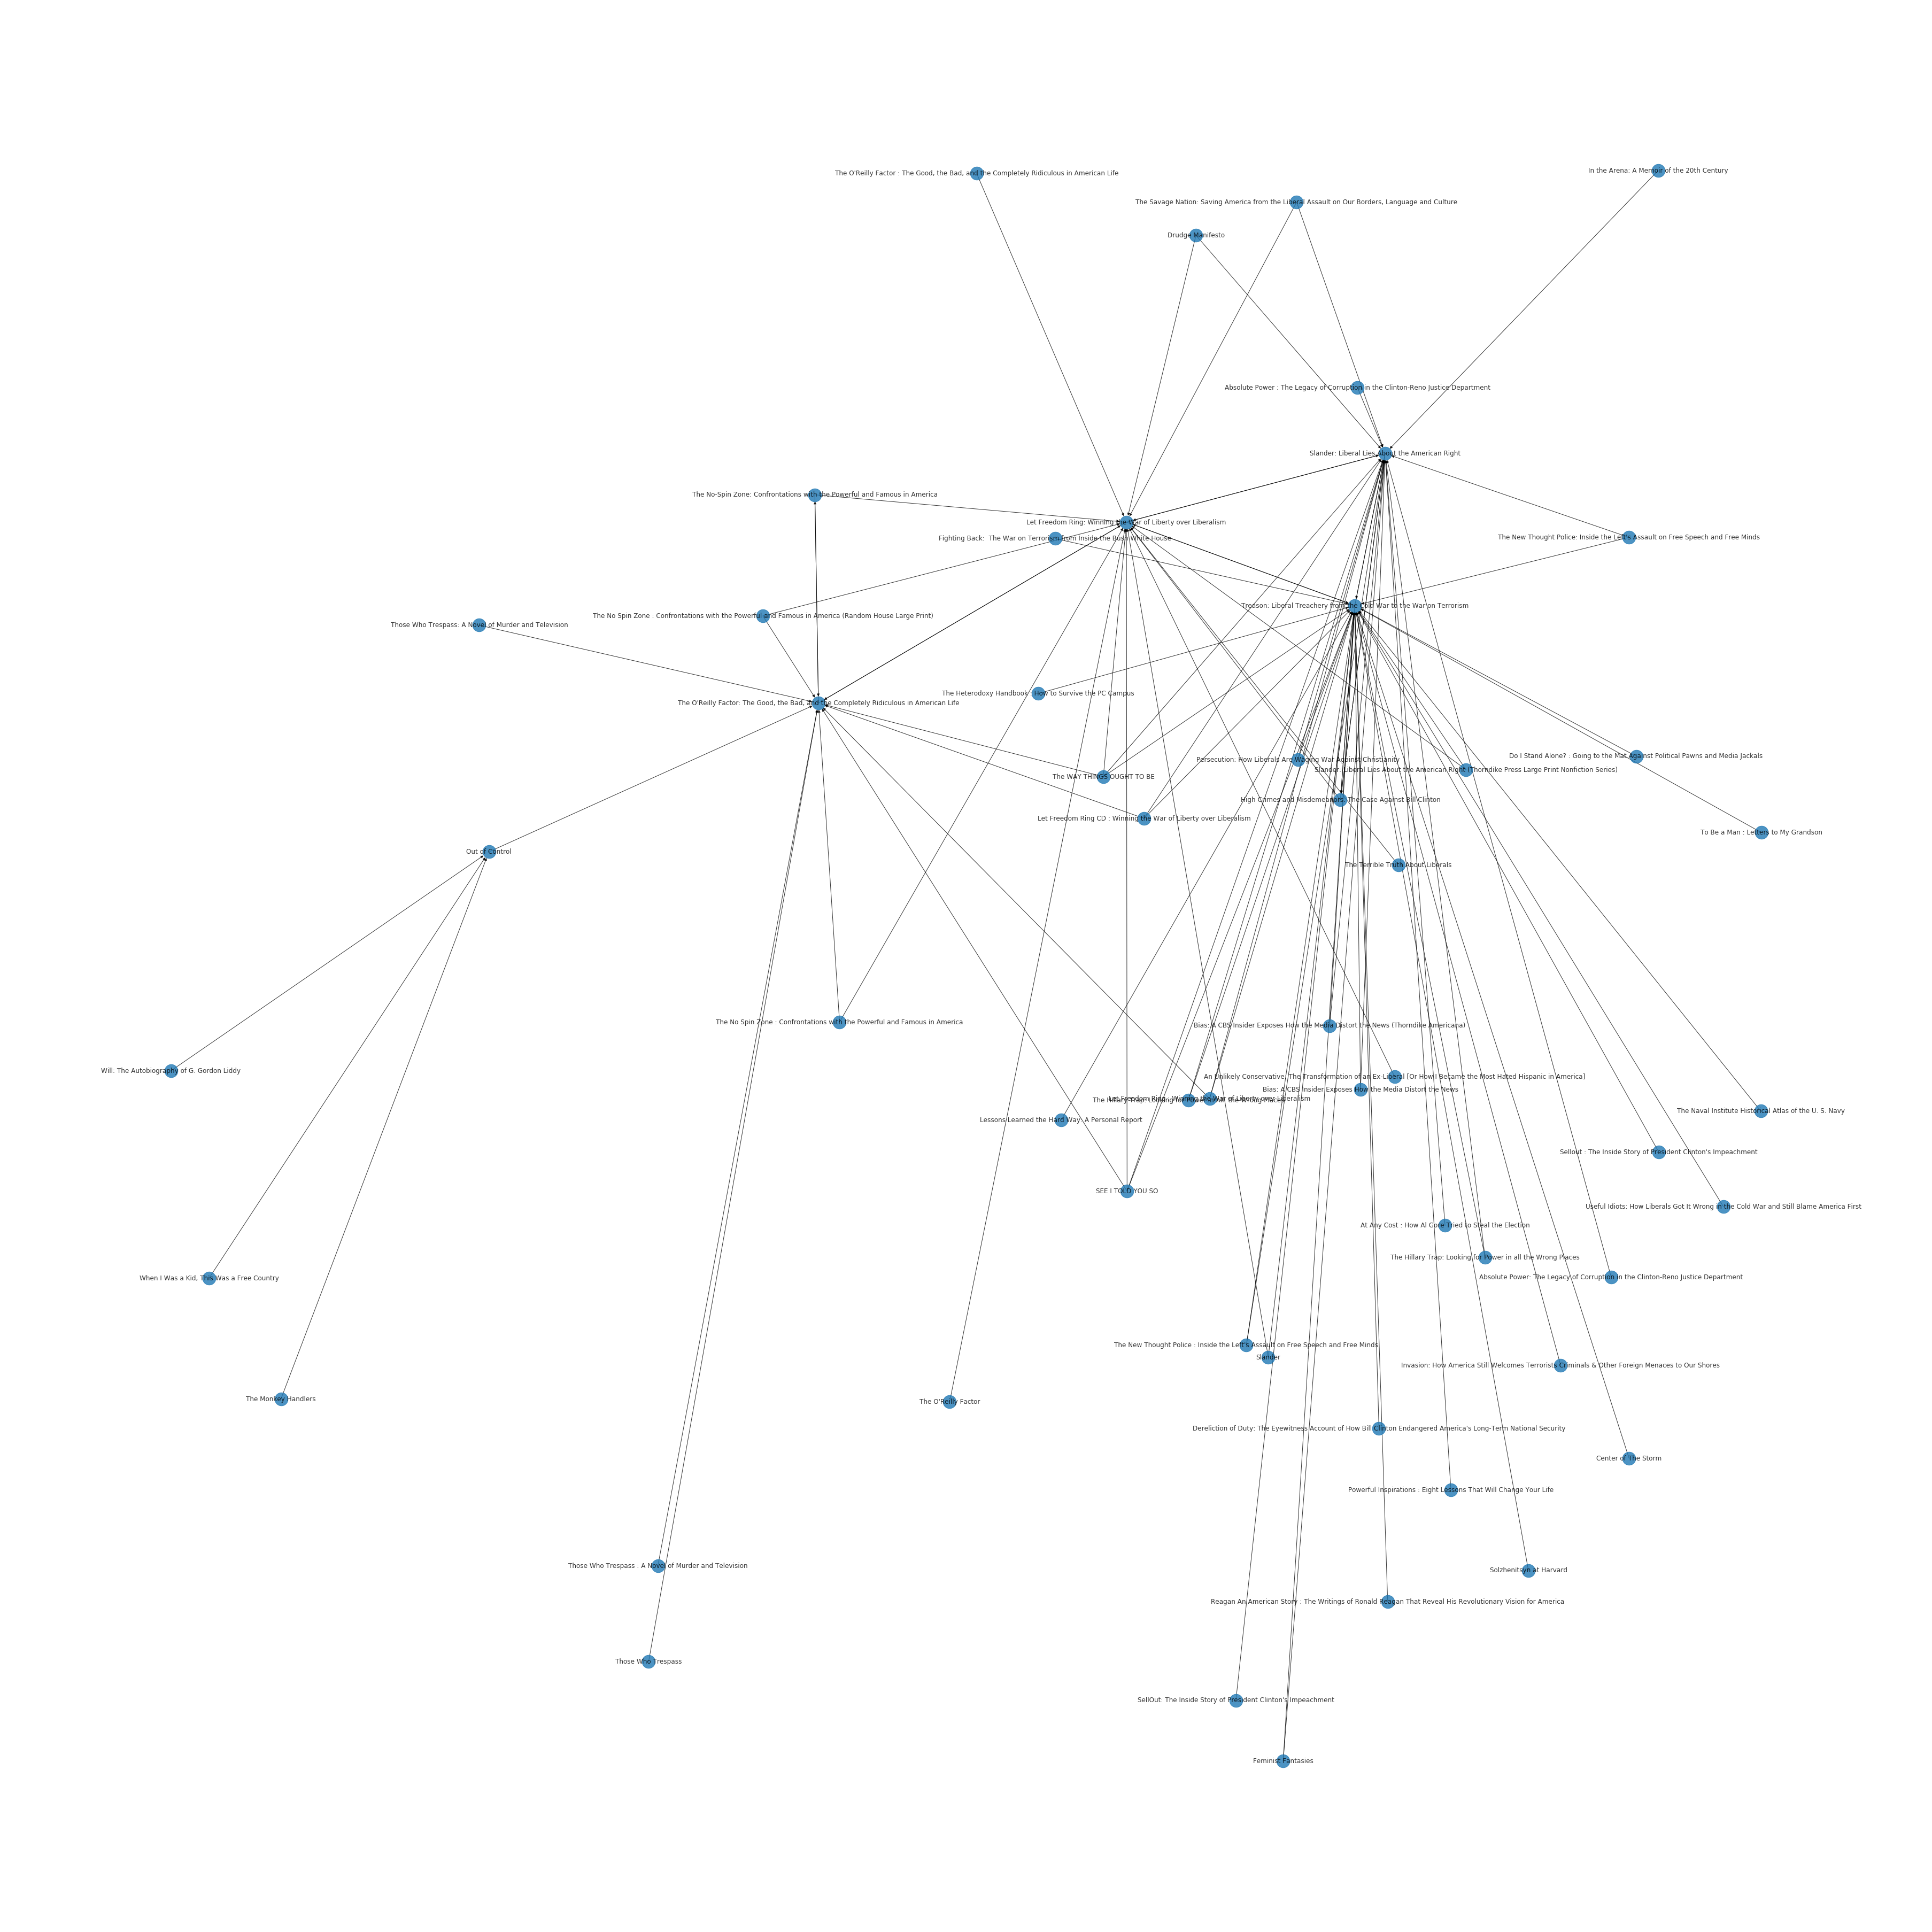

In [57]:
plt.figure(figsize = (50, 50))
nx.draw(nx_g, with_labels = True, node_size = 600, font_size = 12, alpha=0.8, pos=nx.spring_layout(nx_g))  
#nx.draw(nx_g, with_labels = True, node_size = 600, font_size = 12, alpha=0.8, pos=nx.shell_layout(nx_g))

<a id="conclusion"></a>
## Conclusion

In this notebook, we learnt about preprocessing steps required to form a graph.
We learnt about when and how to use Jaccard Similarity and PageRank based on the scenarios. 